    Instructions:
    1. Press Run All (or restart kernel and run all cells).
    2. You will be prompted to provide input values.


    Task 2: Implement a program which,
    – for each unique label l, computes the correspending c most significant clusters associated with the even numbered
    Caltec101 images (using DBScan algorithm); the resulting clusters should be visualized both
        ∗ as differently colored point clouds in a 2-dimensional MDS space, and
        ∗ as groups of image thumbnails.
    AND
    – for the odd numbered images, predicts the most likely labels using the c label-specific clusters.
    The system should also output per-label precision, recall, and F1-score values as well as output an overall accuracy
    value.

In [22]:
FEATURE_SPACE = 'resnet'

C = int(input("C - The number of most significant clusters to find for each label."))

LABEL_INPUT = input(
"""
Options:
1. Provide a label for which you want DBSCAN cluster visualizations, processing will then
stop, and not continue to calculate labelling accuracies for odd images.
2. If blank, we don't display visualizations, but compute accuracies for odd images.
"""
)

from utils.query_input_processor import check_label_is_valid

LABEL_INPUT = check_label_is_valid(LABEL_INPUT) if LABEL_INPUT != "" else ""

Input label:  Faces
Files already downloaded and verified
Output label: Faces 




In [23]:
# Load corresponding feature space.

from utils.database_utils import retrieve
feature_vectors = retrieve(f'{FEATURE_SPACE}.pt')

In [24]:
from utils.dataset_utils import initialize_dataset

dataset = initialize_dataset()

all_labels = dataset.categories

Files already downloaded and verified


In [25]:
# Group latent feature vectors by label.

from utils.vector_utils import get_vectors_for_labels

label_vectors = get_vectors_for_labels(feature_vectors, all_labels)

out_statement = "DBSCAN for C = " + str(C)

Per-label Best Clustering Results using DBSCAN for C = 5 

1 of 101	Best clustering: 5 clusters	Label: Faces


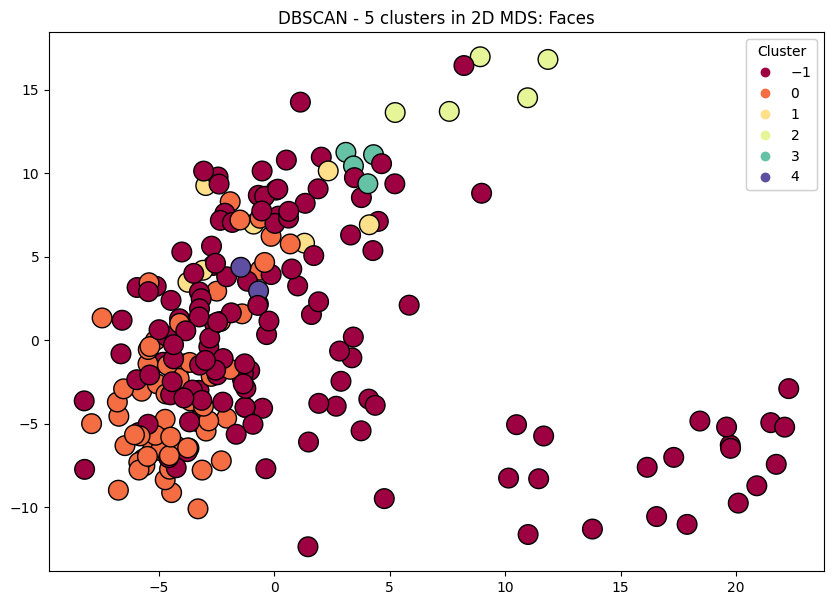

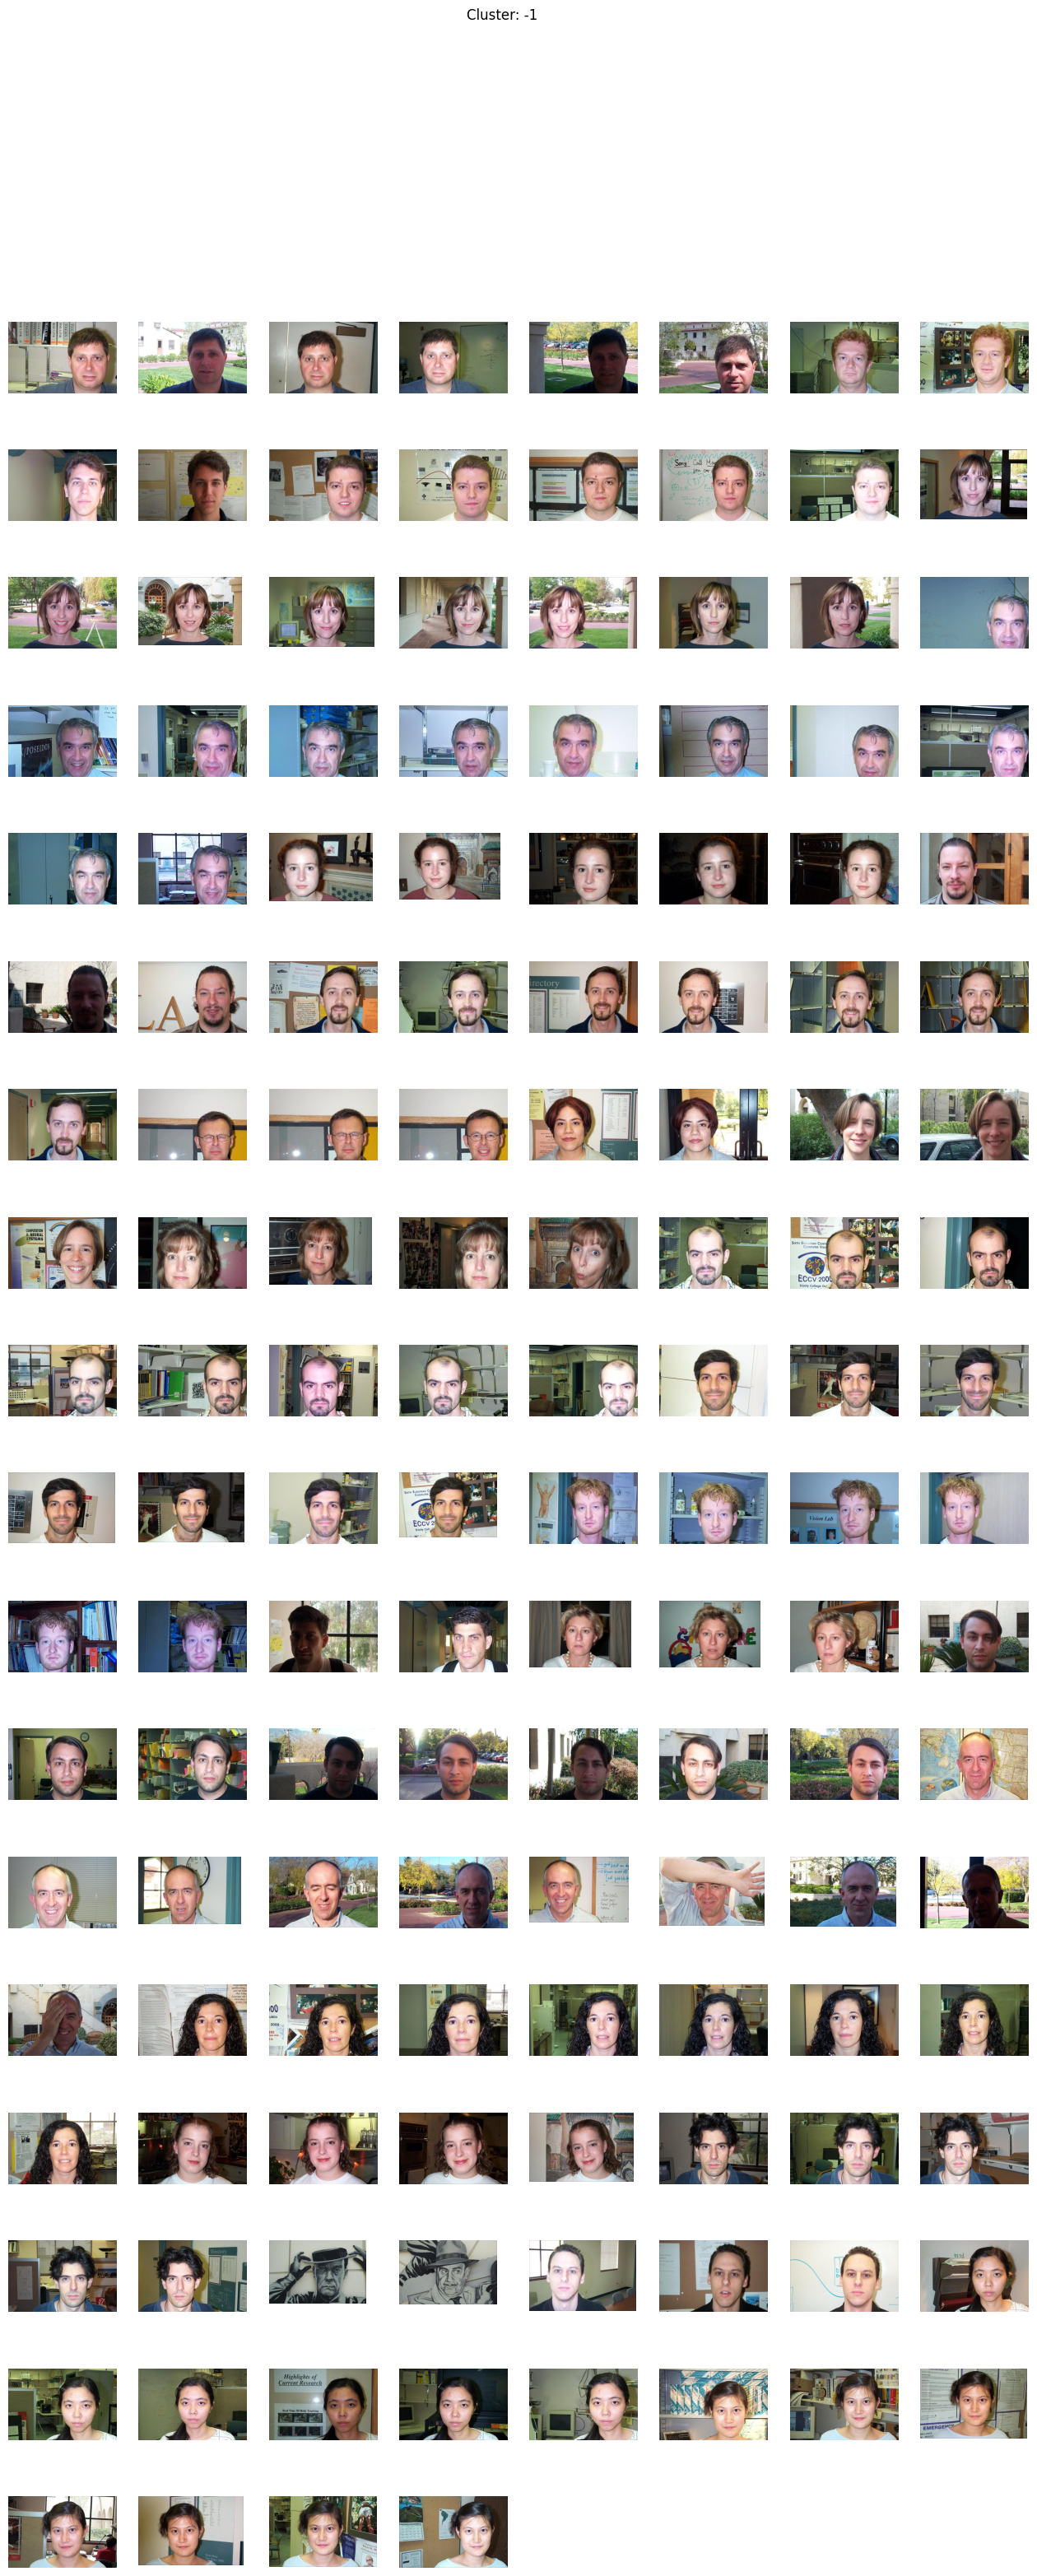

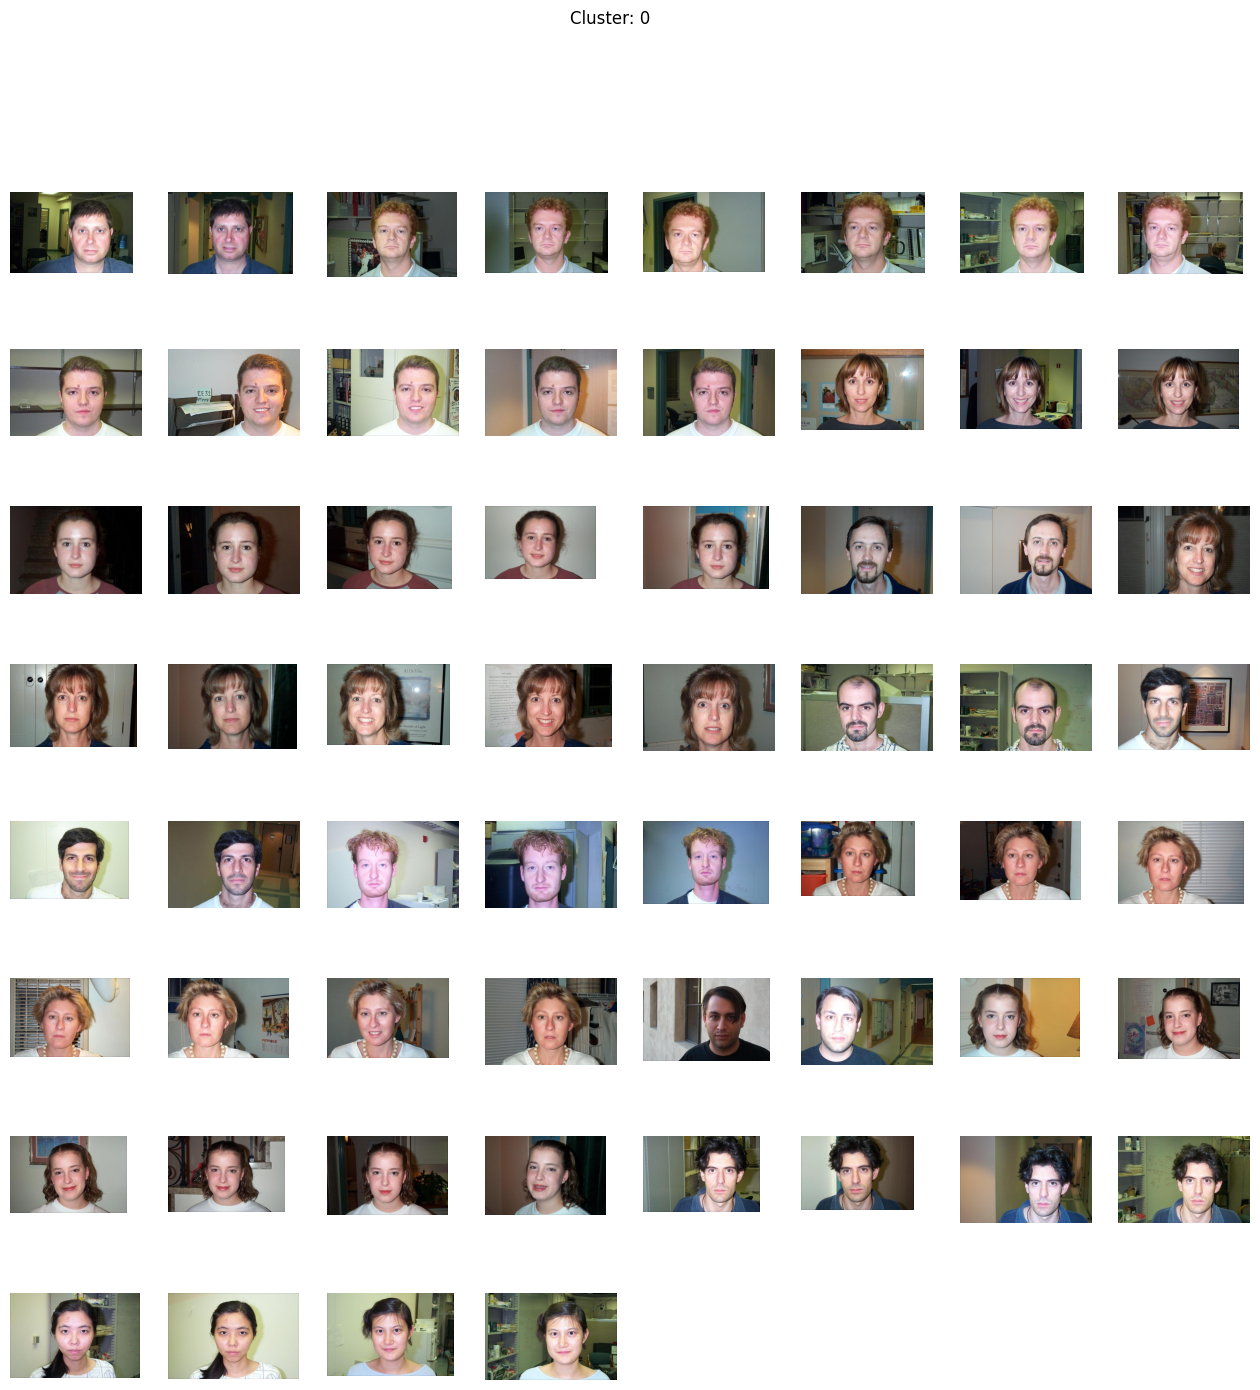

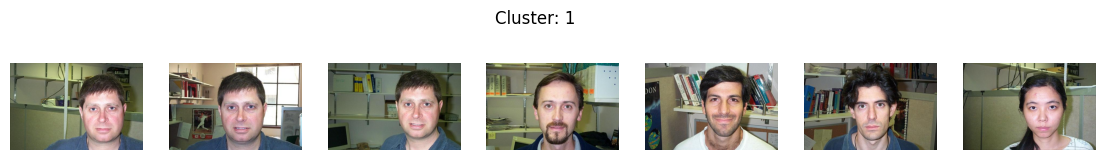

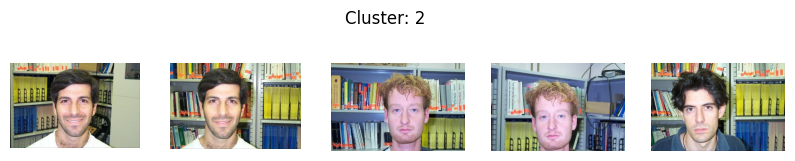

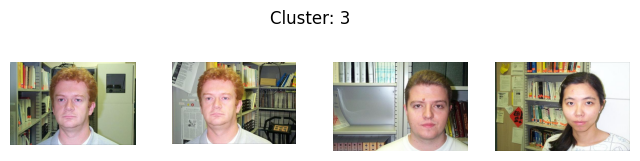

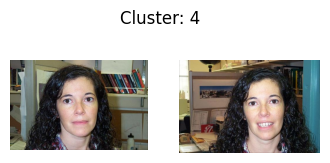

In [26]:
# Iterate for each label, run DBSCAN and cluster each into C clusters.
# We may not always be able to get exactly C clusters, we try to optimize
# parameters to get as close to C clusters as possible.

from feature_reducers.mds import MDSReducer
from classifiers.dbscan import DBSCANClassifer

from utils.vector_utils import get_img_ids_and_vectors

from utils.image_utils import plot_image_thumbnails, plot_2d_scatter_with_color

from scipy.spatial.distance import euclidean

from optimizers.dbscan_optimizer import dbscan_optimal_hyper_parameters

label_cores = {}

print("Per-label Best Clustering Results using", out_statement, "\n")
for label_idx, (label, img_vectors) in enumerate(label_vectors.items()):

    if LABEL_INPUT != "" and LABEL_INPUT != label:
        continue

    img_ids, vectors = get_img_ids_and_vectors(img_vectors)

    EPS, MIN_PTS, best_num_clusters = dbscan_optimal_hyper_parameters(vectors, C, euclidean)

    print(f"{label_idx + 1} of {len(all_labels)}\tBest clustering: {best_num_clusters} clusters\tLabel: {label}")

    DBSCAN = DBSCANClassifer(eps=EPS, minPts=MIN_PTS, dist_fn=euclidean)
    c_labels = DBSCAN.classify(vectors)


    for c_label, core_vectors in DBSCAN.get_cores(vectors).items():
        if label not in label_cores:
            label_cores[label] = []
        label_cores[label].append((core_vectors, EPS))

    if LABEL_INPUT == "":
        continue

    reduced_vectors = MDSReducer(vectors, 2).reduce_features(vectors)

    # Color scatter
    plot_2d_scatter_with_color(
        X=reduced_vectors[:, 0],
        Y=reduced_vectors[:, 1],
        labels=c_labels,
        title=f"DBSCAN - {C} clusters in 2D MDS: {label}"
    )

    # Image thumbnails
    c_label_imgs = {}
    for i in range(len(c_labels)):
        if c_labels[i] not in c_label_imgs:
            c_label_imgs[c_labels[i]] = []
        c_label_imgs[c_labels[i]].append(dataset[img_ids[i]][0])

    c_label_imgs = dict(sorted(c_label_imgs.items()))

    for c_label, images in c_label_imgs.items():
        plot_image_thumbnails(f"Cluster: {c_label}", images, max_cols=8)

In [27]:
if LABEL_INPUT != "":
    raise UserWarning('Not computing accuracies as user only requested visualizations.')

UserWarning: Not computing accuracies as user only requested visualizations.

In [ ]:
# Predict likely labels for all odd images using the DBSCAN clusters.

odd_feature_vectors = retrieve(f'odd{FEATURE_SPACE}.pt')

from utils.vector_utils import flatten_feature_vectors

odd_img_label_vectors = flatten_feature_vectors(odd_feature_vectors)

In [ ]:
# Strategy: Minimum distance to any core vector

from utils.perf_utils import PerLabelPerf

perf_calc = PerLabelPerf(all_labels)

print("Running Predictions for", out_statement)
for tuple in odd_img_label_vectors:
    img_id = tuple[0]
    odd_label = tuple[1]
    odd_vector = tuple[2]

    closest_dist = {}

    for label, cores_eps in label_cores.items():
        if label not in closest_dist:
            closest_dist[label] = 10e30
        for core_vectors, eps in cores_eps:
            for core_vector in core_vectors:
                dist = euclidean(core_vector, odd_vector)
                if dist < closest_dist[label]:
                    closest_dist[label] = dist

    label_dists = sorted(closest_dist.items(), key=lambda x : x[1])

    perf_calc.process_perf(y=odd_label, y_pred=label_dists[0][0])

    print(f"IMG_ID: {img_id}\tTrue label: {odd_label}\tPred labels: {label_dists[0][0], label_dists[1][0], label_dists[2][0]}")

Running Predictions for DBSCAN for C = 5
IMG_ID: 1	True label: Faces	Pred labels: ('Faces', 'accordion', 'nautilus')
IMG_ID: 3	True label: Faces	Pred labels: ('Faces_easy', 'Faces', 'crocodile_head')
IMG_ID: 5	True label: Faces	Pred labels: ('Faces', 'Faces_easy', 'scorpion')
IMG_ID: 7	True label: Faces	Pred labels: ('Faces', 'Faces_easy', 'llama')
IMG_ID: 9	True label: Faces	Pred labels: ('Faces', 'Faces_easy', 'llama')
IMG_ID: 11	True label: Faces	Pred labels: ('Faces', 'Faces_easy', 'scorpion')
IMG_ID: 13	True label: Faces	Pred labels: ('Faces', 'Faces_easy', 'llama')
IMG_ID: 15	True label: Faces	Pred labels: ('Faces_easy', 'scorpion', 'crocodile')
IMG_ID: 17	True label: Faces	Pred labels: ('Faces', 'Faces_easy', 'llama')
IMG_ID: 19	True label: Faces	Pred labels: ('Faces', 'Faces_easy', 'accordion')
IMG_ID: 21	True label: Faces	Pred labels: ('Faces', 'Faces_easy', 'lobster')
IMG_ID: 23	True label: Faces	Pred labels: ('Faces', 'Faces_easy', 'lobster')
IMG_ID: 25	True label: Faces	Pre

In [ ]:
from utils.query_input_processor import align_print

print("Per-label Precision, Recall, F1 Scores for", out_statement + ":\n")
max_label_len = max([len(label) for label in all_labels])
decimals = 4

for label in all_labels:
    precision = str(round(perf_calc.get_precision(label), decimals))
    recall = str(round(perf_calc.get_recall(label), decimals))
    f1_score = str(round(perf_calc.get_f1_score(label), decimals))
    print(f"Label: {align_print(label, max_label_len)}\tPrecision: {align_print(precision, decimals+2)}\tRecall: {align_print(recall, decimals+2)} \t F1 score:{align_print(f1_score, decimals+2)}\t")

print("\n\nOverall accuracy for " + out_statement + f": {perf_calc.get_overall_accuracy() * 100}%")

Per-label Precision, Recall, F1 Scores for DBSCAN for C = 5:

Label: Faces          	Precision: 1.0   	Recall: 0.9816 	 F1 score:0.9907	
Label: Faces_easy     	Precision: 1.0   	Recall: 0.9862 	 F1 score:0.9931	
Label: Leopards       	Precision: 0.9804	Recall: 1.0    	 F1 score:0.9901	
Label: Motorbikes     	Precision: 1.0   	Recall: 0.9799 	 F1 score:0.9899	
Label: accordion      	Precision: 1.0   	Recall: 0.963  	 F1 score:0.9811	
Label: airplanes      	Precision: 0.9888	Recall: 0.885  	 F1 score:0.934 	
Label: anchor         	Precision: 0.6   	Recall: 0.4286 	 F1 score:0.5   	
Label: ant            	Precision: 0.7727	Recall: 0.8095 	 F1 score:0.7907	
Label: barrel         	Precision: 0.9583	Recall: 0.9583 	 F1 score:0.9583	
Label: bass           	Precision: 1.0   	Recall: 0.7407 	 F1 score:0.8511	
Label: beaver         	Precision: 0.8261	Recall: 0.8261 	 F1 score:0.8261	
Label: binocular      	Precision: 0.8   	Recall: 1.0    	 F1 score:0.8889	
Label: bonsai         	Precision: 0.91